In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import json
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [33]:
model_ready_selected = pd.read_csv('/Users/kishohars/Projects/football_valuation_project/data_clean/model_ready_selected.csv')
model_ready_selected = pd.get_dummies(model_ready_selected, columns=['current_club_domestic_competition_id'], drop_first=True)


model_ready_selected['country_of_citizenship'] = model_ready_selected['country_of_citizenship'].replace('Türkiye', 'Turkey')

model_ready_selected.columns

Index(['age', 'minutes_played', 'goals_per90', 'assists_per90', 'position',
       'last_season', 'country_of_citizenship', 'market_value_in_eur',
       'target_log', 'current_club_domestic_competition_id_DK1',
       'current_club_domestic_competition_id_ES1',
       'current_club_domestic_competition_id_FR1',
       'current_club_domestic_competition_id_GB1',
       'current_club_domestic_competition_id_GR1',
       'current_club_domestic_competition_id_IT1',
       'current_club_domestic_competition_id_L1',
       'current_club_domestic_competition_id_NL1',
       'current_club_domestic_competition_id_PO1',
       'current_club_domestic_competition_id_RU1',
       'current_club_domestic_competition_id_SC1',
       'current_club_domestic_competition_id_TR1',
       'current_club_domestic_competition_id_UKR1'],
      dtype='object')

In [35]:
model_ready_selected['last_season'].value_counts()

last_season
2024    6287
2023    3610
2022    2445
2021    2166
2018    2049
2020    2028
2019    1644
2016    1588
2017    1537
2013    1511
2015    1312
2014    1252
2012    1033
Name: count, dtype: int64

In [19]:
league_map = {
    'current_club_domestic_competition_id_DK1': 10,
    'current_club_domestic_competition_id_ES1': 3,
    'current_club_domestic_competition_id_FR1': 5,
    'current_club_domestic_competition_id_GB1': 1,
    'current_club_domestic_competition_id_GR1': 9,
    'current_club_domestic_competition_id_IT1': 2,
    'current_club_domestic_competition_id_L1': 4,
    'current_club_domestic_competition_id_NL1': 6,
    'current_club_domestic_competition_id_PO1': 7,
    'current_club_domestic_competition_id_RU1': 13,
    'current_club_domestic_competition_id_SC1': 11,
    'current_club_domestic_competition_id_TR1': 8,
    'current_club_domestic_competition_id_UKR1': 12
}

def get_league_rank(row):
  for col, rank in league_map.items():
    if row[col] == 1:
      return rank
  return 14


model_ready_selected['league_rank'] = model_ready_selected.apply(get_league_rank, axis = 1)

model_ready_selected.drop(columns=league_map.keys(), inplace=True)

In [20]:
selected_features = [
  'age',
  'goals_per90',
  'assists_per90',
  'position',
  'last_season',
  'league_rank',
  'country_of_citizenship'
]

In [21]:
# defining our  X and y!!
X = model_ready_selected[selected_features]
y = model_ready_selected['target_log']

# Split train/test things for our model!!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (22769, 7), Test shape: (5693, 7)


In [22]:
# One-hot encode 'position' and 'country_of_citizenship' columns in train and test sets
X_train_encoded = pd.get_dummies(X_train, columns=['position', 'country_of_citizenship'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['position', 'country_of_citizenship'], drop_first=True)

# Align columns in train and test sets
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

In [23]:
# Train XGBoost Regressor
xgb = XGBRegressor(n_estimators=200, random_state=42, n_jobs=-1)
xgb.fit(X_train_encoded, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
# predicting things!!
y_pred = xgb.predict(X_test_encoded)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.7130
RMSE: 0.9354
R² Score: 0.6530


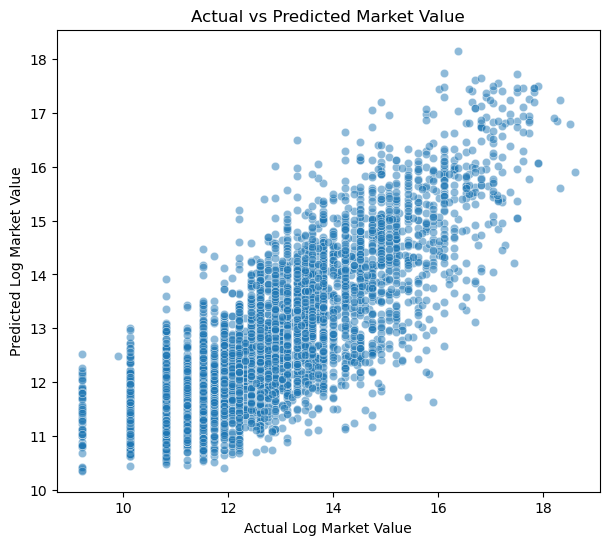

In [25]:
plt.figure(figsize=(7,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Actual Log Market Value")
plt.ylabel("Predicted Log Market Value")
plt.title("Actual vs Predicted Market Value")
plt.show()

In [26]:
cv_scores = cross_val_score(xgb, X_train_encoded, y_train, cv=5, scoring='r2', error_score="raise")
print("Cross-Validation R² Scores:", cv_scores)
mean_cv = np.mean(cv_scores)
print("Mean CV R²:", mean_cv)
if mean_cv < 0.5:
    raise Exception("Model R² score is below acceptable threshold.")

Cross-Validation R² Scores: [0.66162617 0.65224664 0.66131526 0.65553478 0.66332642]
Mean CV R²: 0.6588098536735109


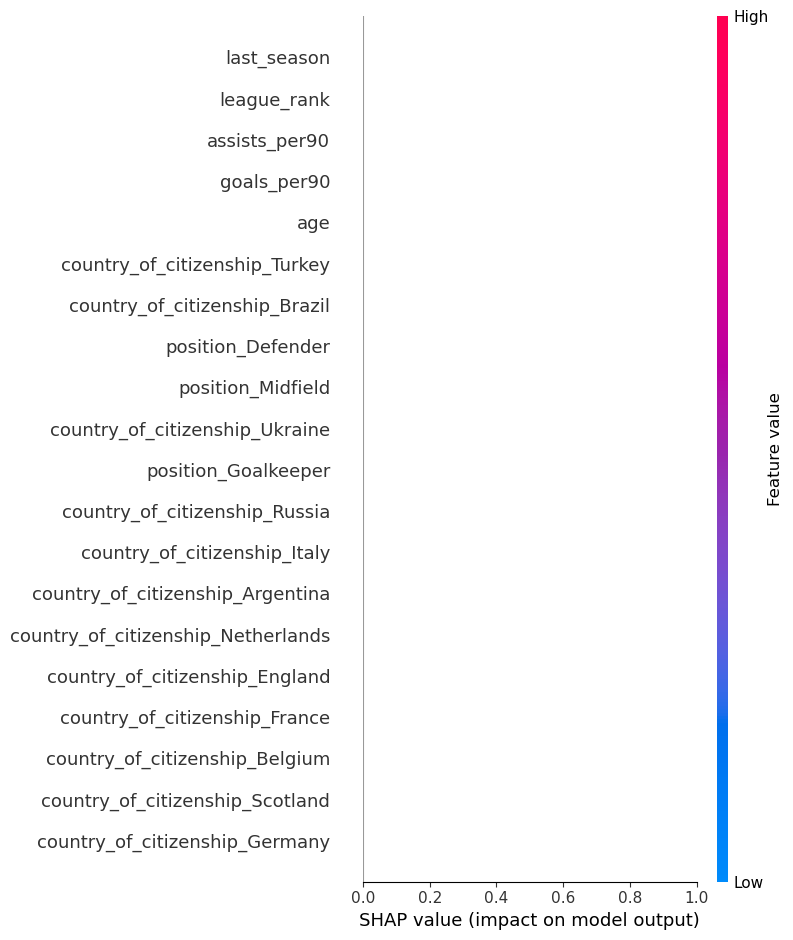

In [27]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train_encoded)
shap.summary_plot(shap_values, X_train_encoded, plot_type="beeswarm")

In [28]:
model_ready_selected = model_ready_selected

model_ready_selected.to_csv('/Users/kishohars/Projects/football_valuation_project/data_clean/datascience_ready.csv', index = False)

In [29]:
import os
model_path = '/Users/kishohars/Projects/football_valuation_project/models/model_ready_selected.pkl'
# Ensure the parent directory exists to avoid FileNotFoundError
os.makedirs(os.path.dirname(model_path), exist_ok=True)
joblib.dump(model_ready_selected, model_path)

['/Users/kishohars/Projects/football_valuation_project/models/model_ready_selected.pkl']

In [30]:
model_features = model_ready_selected.columns.tolist()
joblib.dump(model_features, '/Users/kishohars/Projects/football_valuation_project/models/model_features.pkl')

['/Users/kishohars/Projects/football_valuation_project/models/model_features.pkl']

In [31]:
from sklearn.linear_model import LinearRegression
import joblib
import os

# Prepare features and target explicitly (fixes NameError and ensures categorical encoding)
X = model_ready_selected[selected_features]      # use the previously defined selected_features list
y = model_ready_selected['target_log']           # explicit target column

# One-hot encode categorical columns so LinearRegression receives numeric inputs
X_encoded = pd.get_dummies(X, columns=['position', 'country_of_citizenship'], drop_first=True)

# Train the model
model = LinearRegression()
model.fit(X_encoded, y)

# Save paths (use distinct filenames so we don't overwrite earlier artifacts)
model_path = "/Users/kishohars/Projects/football_valuation_project/models/linear_regression.pkl"
features_path = "/Users/kishohars/Projects/football_valuation_project/models/linear_regression_features.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model and feature names
joblib.dump(model, model_path)
joblib.dump(X_encoded.columns.tolist(), features_path)

print("LinearRegression model trained and saved:", model_path)


LinearRegression model trained and saved: /Users/kishohars/Projects/football_valuation_project/models/linear_regression.pkl
